Trial 5 Complete [00h 00m 03s]
val_loss: 986820480.0

Best val_loss So Far: 808373056.0
Total elapsed time: 00h 00m 14s
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5723859456.0000 - mean_squared_error: 5723859456.0000
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5695168512.0000 - mean_squared_error: 5695168512.0000 
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5625106432.0000 - mean_squared_error: 5625106432.0000 
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5469874688.0000 - mean_squared_error: 5469874688.0000 
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5163002880.0000 - mean_squared_error: 5163002880.0000 
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4616048640.0000 - mean_squared_error: 4616048640.0000 
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3750904320.0000 - mean_squared_error: 3750904320.0000 
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2595609344.0000 - mean_squared_error: 2595609344

/opt/anaconda3/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - loss: 1976653952.0000 - mean_squared_error: 1976653952.0000
Тестовая потеря: 1976653952.0, Тестовая точность: 1976653952.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


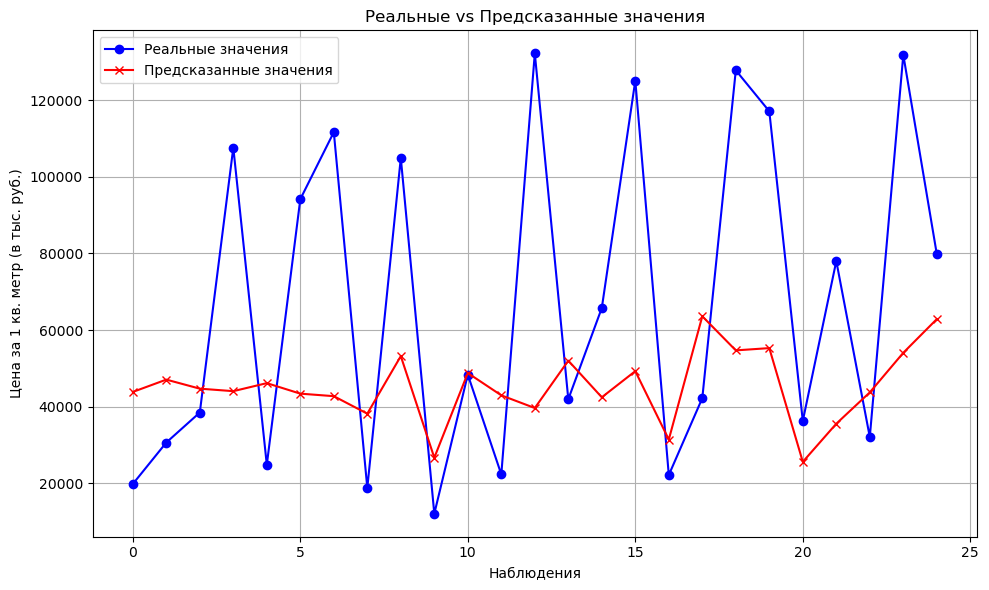

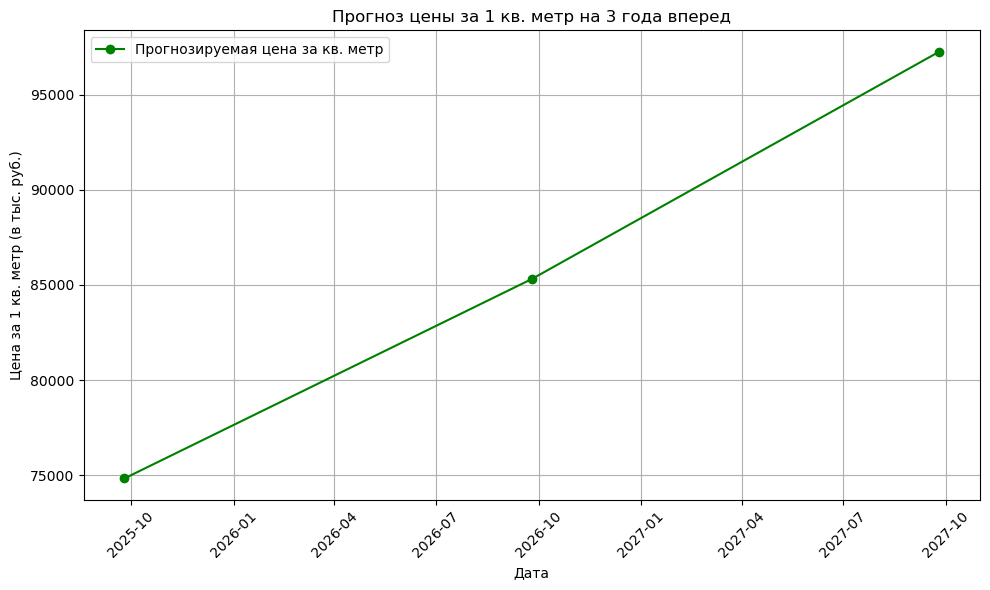

In [6]:
# Генеративно-состязательная сеть (GANs)
# Обучение на малом датафрейме


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import autokeras as ak
from datetime import datetime, timedelta

# Функция для валидации ввода
def validate_input(prompt, min_value=None, max_value=None):
    while True:
        try:
            value = float(input(prompt).replace(",", "."))
            if min_value is not None and value < min_value:
                print(f"Значение должно быть не меньше {min_value}.")
                continue
            if max_value is not None and value > max_value:
                print(f"Значение должно быть не больше {max_value}.")
                continue
            return value
        except ValueError:
            print("Ошибка: Введите корректное число.")

# Загрузка данных
file_path = '/Users/ilyalevshenkov/_GB/GB_Diplom/Sale/Москва_sale_filtered_data.csv'
data = pd.read_csv(file_path)
print(f"Загруженные колонки: {list(data.columns)}")

# Ввод ставки Банка России и процента инфляции с валидацией
bank_rate = validate_input("Введите значение ставки Банка России (в %): ", min_value=0, max_value=100)
inflation_rate = validate_input("Введите процент инфляции (в %): ", min_value=0, max_value=100)

# Обработка данных: корректировка цены на основе ставки банка и инфляции
data['adjusted_price'] = data['price'] * (1 + bank_rate / 100) * (1 + inflation_rate / 100)

# Приведение всех цен к тысячам рублей
data['price'] = data['price'] / 1000  # Приведение цены к тыс. руб.
data['adjusted_price'] = data['adjusted_price'] / 1000  # Приведение скорректированной цены к тыс. руб.

# Обработка категориальных данных
label_encoder = LabelEncoder()
categorical_columns = data.select_dtypes(include=['object']).columns

# Применяем LabelEncoder к каждой категориальной колонке
for col in categorical_columns:
    data[col] = label_encoder.fit_transform(data[col].astype(str))

# Предобработка данных
X = data.drop(['price', 'adjusted_price'], axis=1)  # Убираем цену и скорректированную цену из признаков
y = data['adjusted_price']  # Целевая переменная — скорректированная цена

# Разделение данных на тренировочные и тестовые выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Преобразуем данные в numpy массивы
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

# ----- AutoML с использованием AutoKeras -----

# Создание модели AutoKeras
model = ak.AutoModel(
    inputs=ak.Input(),
    outputs=ak.RegressionHead(),
    overwrite=True,
    max_trials=5
)

# Обучение модели
model.fit(X_train, y_train, epochs=10)

# Оценка модели
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Тестовая потеря: {loss}, Тестовая точность: {accuracy}")

# Прогнозирование
y_pred = model.predict(X_test)

# ----- Визуализация результатов -----

# График реальных и предсказанных значений
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Реальные значения', color='blue', marker='o')
plt.plot(y_pred, label='Предсказанные значения', color='red', marker='x')
plt.title('Реальные vs Предсказанные значения')
plt.xlabel('Наблюдения')
plt.ylabel('Цена за 1 кв. метр (в тыс. руб.)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# ----- График прогноза цены 1 кв. метра на три года вперед -----

# Прогноз стоимости 1 кв. метра на 3 года вперед
current_date = datetime.now()  # Используем текущее время как дату загрузки
future_dates = [current_date + timedelta(days=365 * i) for i in range(1, 4)]

# Используем среднюю цену за квадратный метр для прогнозирования
average_price_per_sqm = data['adjusted_price'].mean()  # Измените на вашу колонку, содержащую цену за кв. метр

# Прогнозируемая стоимость с учетом инфляции
future_prices = []
for date in future_dates:
    average_price_per_sqm *= (1 + inflation_rate / 100)  # Увеличиваем цену на процент инфляции
    future_prices.append(average_price_per_sqm)

# Визуализация прогноза стоимости 1 кв. метра
plt.figure(figsize=(10, 6))
plt.plot(future_dates, future_prices, marker='o', color='green', label='Прогнозируемая цена за кв. метр')
plt.title("Прогноз цены за 1 кв. метр на 3 года вперед")
plt.xlabel("Дата")
plt.ylabel("Цена за 1 кв. метр (в тыс. руб.)")
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


Trial 5 Complete [00h 00m 02s]
val_loss: 4048158208.0

Best val_loss So Far: 3693139712.0
Total elapsed time: 00h 00m 12s
Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5478248611840.0000 - mean_squared_error: 5478248611840.0000
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6731451392.0000 - mean_squared_error: 6731451392.0000 
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6649963008.0000 - mean_squared_error: 6649963008.0000 
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6569745920.0000 - mean_squared_error: 6569745920.0000 
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6490778624.0000 - mean_squared_error: 6490778624.0000 
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6413043712.0000 - mean_squared_error: 6413043712.0000 
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6336519680.0000 - mean_squared_error: 6336519680.0000 
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6261188608.0000 - mean_squared_error: 62

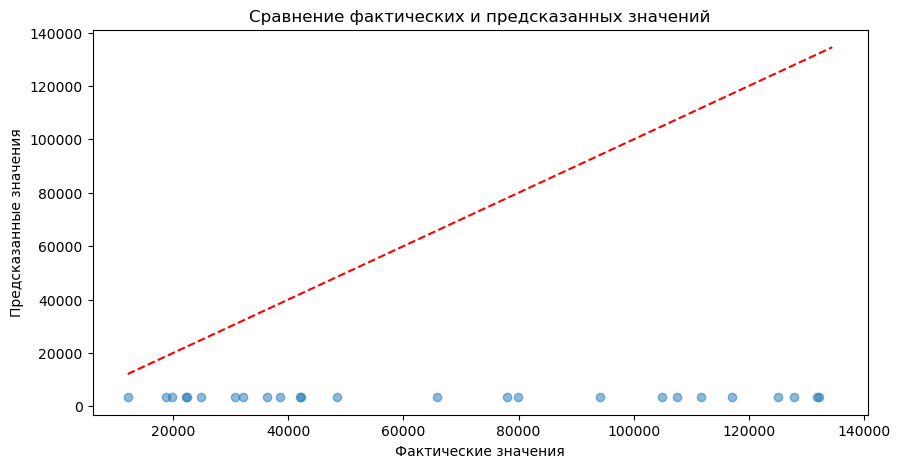

In [10]:
# Генеративно-состязательная сеть (GANs)
# Обучение на малом датафрейме


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import autokeras as ak

# Функция для валидации ввода
def validate_input(prompt, min_value=None, max_value=None):
    while True:
        try:
            value = float(input(prompt).replace(",", "."))
            if min_value is not None and value < min_value:
                print(f"Значение должно быть не меньше {min_value}.")
                continue
            if max_value is not None and value > max_value:
                print(f"Значение должно быть не больше {max_value}.")
                continue
            return value
        except ValueError:
            print("Ошибка: Введите корректное число.")

# Загрузка данных
file_path = '/Users/ilyalevshenkov/_GB/GB_Diplom/Sale/Москва_sale_filtered_data.csv'
data = pd.read_csv(file_path)
print(f"Загруженные колонки: {list(data.columns)}")

# Ввод ставки Банка России и процента инфляции с валидацией
bank_rate = validate_input("Введите значение ставки Банка России (в %): ", min_value=0, max_value=100)
inflation_rate = validate_input("Введите процент инфляции (в %): ", min_value=0, max_value=100)

# Обработка данных: корректировка цены на основе ставки банка и инфляции
data['adjusted_price'] = data['price'] * (1 + bank_rate / 100) * (1 + inflation_rate / 100)

# Приведение всех цен к тысячам рублей
data['price'] = data['price'] / 1000  # Приведение цены к тыс. руб.
data['adjusted_price'] = data['adjusted_price'] / 1000  # Приведение скорректированной цены к тыс. руб.

# Обработка категориальных данных
data = pd.get_dummies(data)  # One-hot encoding для категориальных признаков

# Предобработка данных
X = data.drop(['price', 'adjusted_price'], axis=1)  # Убираем цену и скорректированную цену из признаков
y = data['adjusted_price']  # Целевая переменная — скорректированная цена

# Разделение данных на тренировочные и тестовые выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Нормализация данных
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Преобразование целевой переменной в numpy.ndarray
y_train = y_train.values
y_test = y_test.values

# ----- AutoML с использованием AutoKeras -----

# Создание модели AutoKeras
model = ak.AutoModel(
    inputs=ak.Input(shape=(X_train.shape[1],)),  # Указание формы входа
    outputs=ak.RegressionHead(),
    overwrite=True,
    max_trials=5
)

# Обучение модели
model.fit(X_train, y_train, epochs=20, validation_split=0.2)

# Оценка модели
loss, mae = model.evaluate(X_test, y_test)

# Вывод результатов
print(f"Тестовая потеря: {loss}, Тестовая средняя абсолютная ошибка: {mae}")

# Прогнозирование
predictions = model.predict(X_test)

# Визуализация прогноза
plt.figure(figsize=(10, 5))
plt.scatter(y_test, predictions, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # Линия y=x
plt.title("Сравнение фактических и предсказанных значений")
plt.xlabel("Фактические значения")
plt.ylabel("Предсказанные значения")
plt.show()


Trial 5 Complete [00h 00m 02s]
val_loss: 7459004416.0

Best val_loss So Far: 7458341888.0
Total elapsed time: 00h 00m 14s
Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6548519936.0000 - mean_squared_error: 6548519936.0000
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6548480000.0000 - mean_squared_error: 6548480000.0000 
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6548438016.0000 - mean_squared_error: 6548438016.0000 
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6548392448.0000 - mean_squared_error: 6548392448.0000 
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6548342272.0000 - mean_squared_error: 6548342272.0000 
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6548285440.0000 - mean_squared_error: 6548285440.0000 
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6548220928.0000 - mean_squared_error: 6548220928.0000 
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6548145664.0000 - mean_squared_error: 65481456

/opt/anaconda3/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6733612544.0000 - mean_squared_error: 6733612544.0000  
Тестовая потеря: 6759140864.0, Тестовая точность: 6759140864.0
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


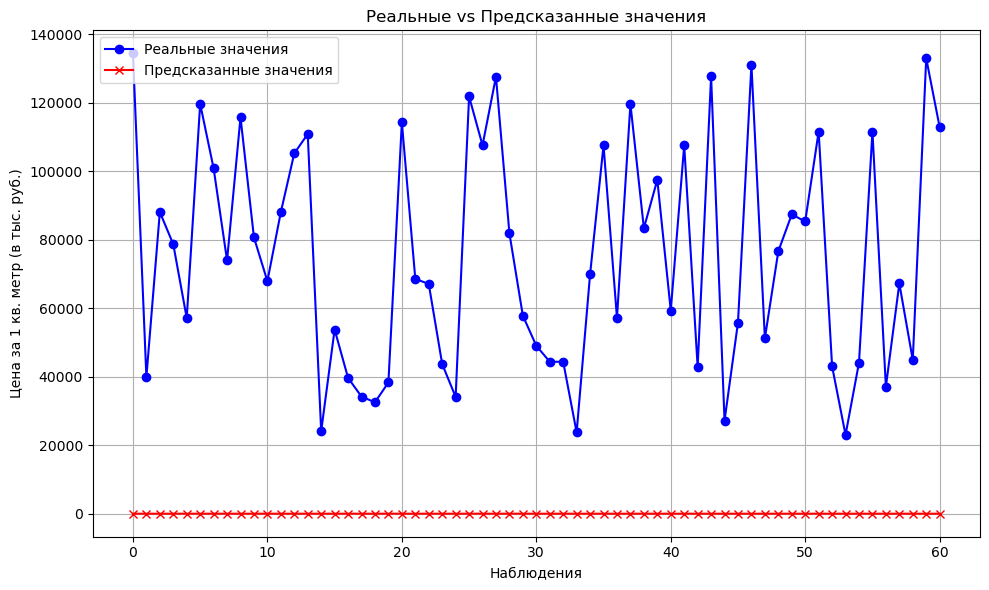

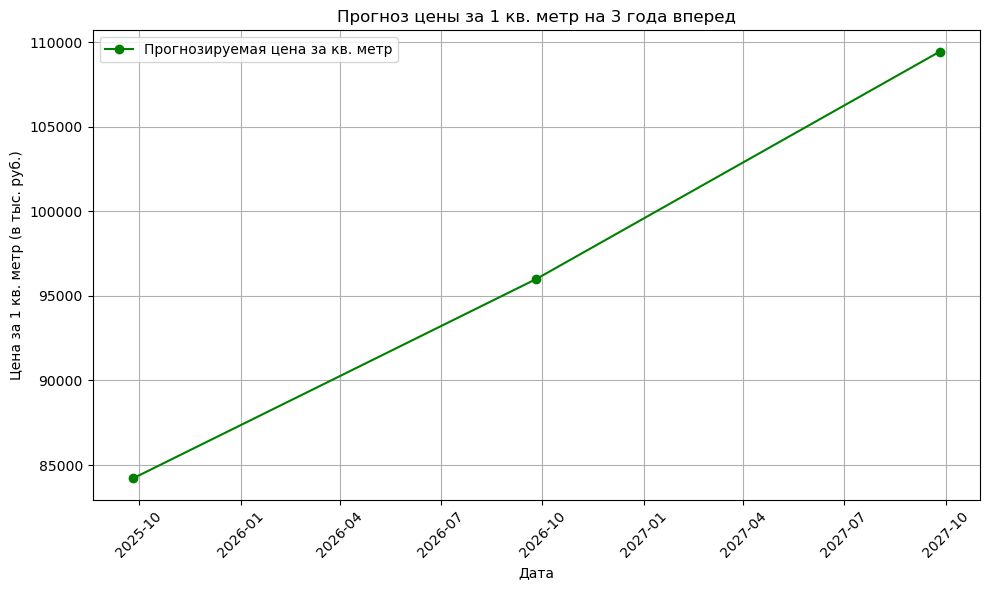

In [11]:
# Генеративно-состязательная сеть (GANs)
# Обучение на датафрейме 494 объекта

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import autokeras as ak
from datetime import datetime, timedelta

# Функция для валидации ввода
def validate_input(prompt, min_value=None, max_value=None):
    while True:
        try:
            value = float(input(prompt).replace(",", "."))
            if min_value is not None and value < min_value:
                print(f"Значение должно быть не меньше {min_value}.")
                continue
            if max_value is not None and value > max_value:
                print(f"Значение должно быть не больше {max_value}.")
                continue
            return value
        except ValueError:
            print("Ошибка: Введите корректное число.")

# Загрузка данных
file_path = '/Users/ilyalevshenkov/_GB/GB_Diplom/Sale/Москва_sale_filtered_data.csv'
data = pd.read_csv(file_path)
print(f"Загруженные колонки: {list(data.columns)}")

# Ввод ставки Банка России и процента инфляции с валидацией
bank_rate = validate_input("Введите значение ставки Банка России (в %): ", min_value=0, max_value=100)
inflation_rate = validate_input("Введите процент инфляции (в %): ", min_value=0, max_value=100)

# Обработка данных: корректировка цены на основе ставки банка и инфляции
data['adjusted_price'] = data['price'] * (1 + bank_rate / 100) * (1 + inflation_rate / 100)

# Приведение всех цен к тысячам рублей
data['price'] = data['price'] / 1000  # Приведение цены к тыс. руб.
data['adjusted_price'] = data['adjusted_price'] / 1000  # Приведение скорректированной цены к тыс. руб.

# Проверка на пропущенные значения
print("Проверка на пропущенные значения:\n", data.isnull().sum())

# Проверка на бесконечные значения только для числовых колонок
inf_check = data.select_dtypes(include=[np.number]).apply(np.isinf).any(axis=1)
print("Проверка на бесконечные значения:\n", inf_check.sum())

# Удаление строк с NaN и inf
data = data.dropna()
data = data[~inf_check]  # Исправлено: используем ~inf_check для удаления

# Обработка категориальных данных
label_encoder = LabelEncoder()
categorical_columns = data.select_dtypes(include=['object']).columns

# Применяем LabelEncoder к каждой категориальной колонке
for col in categorical_columns:
    data[col] = label_encoder.fit_transform(data[col].astype(str))

# Предобработка данных
X = data.drop(['price', 'adjusted_price'], axis=1)  # Убираем цену и скорректированную цену из признаков
y = data['adjusted_price']  # Целевая переменная — скорректированная цена

# Разделение данных на тренировочные и тестовые выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Нормализация данных
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Преобразуем данные в numpy массивы
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

# ----- AutoML с использованием AutoKeras -----

# Создание модели AutoKeras
model = ak.AutoModel(
    inputs=ak.Input(shape=(X_train.shape[1],)),  # Указание формы входных данных
    outputs=ak.RegressionHead(),
    overwrite=True,
    max_trials=5
)

# Обучение модели
model.fit(X_train, y_train, epochs=10)

# Оценка модели
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Тестовая потеря: {loss}, Тестовая точность: {accuracy}")

# Прогнозирование
y_pred = model.predict(X_test)

# ----- Визуализация результатов -----

# График реальных и предсказанных значений
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Реальные значения', color='blue', marker='o')
plt.plot(y_pred, label='Предсказанные значения', color='red', marker='x')
plt.title('Реальные vs Предсказанные значения')
plt.xlabel('Наблюдения')
plt.ylabel('Цена за 1 кв. метр (в тыс. руб.)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# ----- График прогноза цены 1 кв. метра на три года вперед -----

# Прогноз стоимости 1 кв. метра на 3 года вперед
current_date = datetime.now()  # Используем текущее время как дату загрузки
future_dates = [current_date + timedelta(days=365 * i) for i in range(1, 4)]

# Используем среднюю цену за квадратный метр для прогнозирования
average_price_per_sqm = data['adjusted_price'].mean()  # Измените на вашу колонку, содержащую цену за кв. метр

# Прогнозируемая стоимость с учетом инфляции
future_prices = []
for date in future_dates:
    average_price_per_sqm *= (1 + inflation_rate / 100)  # Увеличиваем цену на процент инфляции
    future_prices.append(average_price_per_sqm)

# Визуализация прогноза стоимости 1 кв. метра
plt.figure(figsize=(10, 6))
plt.plot(future_dates, future_prices, marker='o', color='green', label='Прогнозируемая цена за кв. метр')
plt.title("Прогноз цены за 1 кв. метр на 3 года вперед")
plt.xlabel("Дата")
plt.ylabel("Цена за 1 кв. метр (в тыс. руб.)")
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()